<center><h1><b> ECON3203 Group Assignment Last Updated: 12th November 12:12am </h1></center><b>
<br>
This is a group assignment for ECON3203 with the following members: Dong (Tony) Min, Joseph Chung, Min-Sik Son, Seoyeon Park.
<br>
<br>
<center>    Today is Tony's birthday! Happy 21st birthday Tony! </center>

<a class="buttom" href="#Task-Overview">Task Overview</a> <br>
<a class="buttom" href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#Splitting-Training-and-Testing-Data">Splitting Training and Testing Data</a> <br>
<a class="buttom" href="#Adding-Interaction-Terms">Adding Interaction Terms</a> <br>
<a class="buttom" href="#Standardisation">Standardisation</a> <br>
<a class="buttom" href="#Multiple-Linear-Regression-Model">Multiple Linear Regression Model</a> <br>
<a class="buttom" href="#Lasso,-Ridge-and-ElasticNet">Lasso, Ridge and ElasticNet</a>
- <a class="buttom" href="#Lasso">Lasso</a> <br>
- <a class="buttom" href="#Ridge">Ridge</a> <br>
- <a class="buttom" href="#ElasticNet">ElasticNet</a> <br>
- <a class="buttom" href="#Lasso,-Ridge,-ElasticNet-CV-Results">Lasso, Ridge, ElasticNet CV Results</a>

<a class="buttom" href="#K-Nearest-Neighbours-Model">K-Nearest Neighbours Model</a> <br>
    <br>

# Task Overview

Developing a predictive model for ATM cash demand is an important task for every bank. Suppose that you are employed by a bank, and your task is to optimise the bank’s cash management by making smarter decisions about reloading its ATM network. <br> <br>
Your task is to develop a model for predicting the cash demand Withdraw based on the covariates.

# Exploratory Data Analysis

Load the given training dataset.

In [13]:
import pandas as pd
import numpy as np
import random
import warnings

warnings.filterwarnings('ignore')
random.seed(10)
data = pd.read_csv("ATM_training.csv")
data.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
0,10.18,10,1,0,0,0,72.750556
1,9.74,10,1,1,0,0,66.720482
2,0.96,2,0,0,0,1,19.189516
3,9.58,9,1,1,0,1,67.388669
4,1.03,4,0,1,0,1,15.813127


Using the .head() function we can observe the variables in our dataset. <br>
We have a total of 7 variables in our dataset. <br> <br>
Next let us check how many NULL values exist in our dataset.

In [14]:
data.isnull().sum()

Shops       0
ATMs        0
Downtown    0
Weekday     0
Center      0
High        0
Withdraw    0
dtype: int64

From the results above, we can see that no NULL values exist in our dataset and thus, we do not need to clean the dataset.

# Splitting Training and Testing Data

In [15]:
train = data.sample(frac = 0.7, random_state = 1)
test = data[data.index.isin(train.index) == False].copy()

# Adding Interaction Terms

Observe the correlation of features from the dataset. We'll have a look at the correlation between our response 'Withdraw' with the other independent variables.

In [16]:
correlations = data.corr()
print(correlations.iloc[:, 6])

Shops       0.985797
ATMs        0.824030
Downtown    0.983574
Weekday    -0.050470
Center      0.088103
High        0.021275
Withdraw    1.000000
Name: Withdraw, dtype: float64


From these predictors, it seems 'Shops, ATMs, Downtown' have considerably large linear sample correlations with 'Withdraw'.

But should we really include all these features into our model? Let's take a look at the correlation matrix.

In [17]:
correlations

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000000,0.872903,0.999131,0.013014,0.000004,0.001820,0.985797
ATMs,0.872903,1.000000,0.873726,0.009766,-0.003306,-0.002616,0.824030
Downtown,0.999131,0.873726,1.000000,0.012664,-0.000101,0.001782,0.983574
Weekday,0.013014,0.009766,0.012664,1.000000,-0.007153,-0.006793,-0.050470
Center,0.000004,-0.003306,-0.000101,-0.007153,1.000000,0.010521,0.088103
High,0.001820,-0.002616,0.001782,-0.006793,0.010521,1.000000,0.021275
Withdraw,0.985797,0.824030,0.983574,-0.050470,0.088103,0.021275,1.000000


If we have a look at the correlation between 'Shops' and 'Downtown', there is a very high correlation between these two features. Similarly for 'Downtown' and 'ATMs'. Including these features could overfit our model and raise issue to multicollinearity. So how do we deal with this problem?

For now, Shops, Downtown, ATMs are highly correlated predictors so we will now attempt to create interaction terms with them.

Common interaction terms are $X^2$ and $XY$.

However, for example, the predictor 'Downtown_SQ' will not be used as it is identical to the predictor 'Downtown'. <br>
e.g. $0 = 0\times0$ <br>
e.g. $1 = 1\times1$

Adding interaction terms to both the training and testing set:

In [18]:
train['Shops_ATM'] = train['Shops'] * train['ATMs']
train['Shops_Down'] = train['Shops'] * train['Downtown']
train['Down_ATM'] = train['Downtown'] * train['ATMs']

train['Shops_SQ'] = train['Shops'] * train['Shops']
train['ATM_SQ'] = train['ATMs'] * train['ATMs']

In [19]:
test['Shops_ATM'] = test['Shops'] * test['ATMs']
test['Shops_Down'] = test['Shops'] * test['Downtown']
test['Down_ATM'] = test['Downtown'] * test['ATMs']

test['Shops_SQ'] = test['Shops'] * test['Shops']
test['ATM_SQ'] = test['ATMs'] * test['ATMs']

Create a copy of the unstandardised training and testing dataset used later:

In [20]:
train_copy = train.copy()
test_copy = test.copy()

# Standardisation

We want to standardise predictors in our model so that we can put different variables on the same scale. This allows you to compare scores between different types of variables. This will require us to achieve zero mean and unit standard deviation after standardisation.

In [21]:
response = ['Withdraw']
predictors = [x for x in list(train.columns) if x not in response]
mu = train[predictors].mean()
sigma = train[predictors].std()
print("Numerical predictors in Model are:")
print(predictors)

Numerical predictors in Model are:
['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_ATM', 'Shops_Down', 'Down_ATM', 'Shops_SQ', 'ATM_SQ']


Mean and standard deviation of each numerical predictor in model before standardisation:

In [22]:
print("Mean for each numerical predictor:")
print(mu)
print("\n")
print("Standard deviation for each numerical predictor:")
print(sigma)

Mean for each numerical predictor:
Shops          7.301158
ATMs           7.915065
Downtown       0.700325
Weekday        0.713766
Center         0.103312
High           0.302987
Shops_ATM     70.981819
Shops_Down     7.001469
Down_ATM       7.009545
Shops_SQ      70.325855
ATM_SQ        76.076623
dtype: float64


Standard deviation for each numerical predictor:
Shops          4.125536
ATMs           3.664593
Downtown       0.458131
Weekday        0.452015
Center         0.304375
High           0.459565
Shops_ATM     47.600942
Shops_Down     4.583251
Down_ATM       4.887630
Shops_SQ      45.474419
ATM_SQ        55.164696
dtype: float64


Standardise the predictors in both training and test data. Note we must use the same mean and standard deviation calculated based on the training data.

In [23]:
train[predictors]=(train[predictors]-mu)/sigma
test[predictors]=(test[predictors]-mu)/sigma

Mean and standard deviation of each numerical predictor in model after standardisation:

In [24]:
print("Mean for each numerical predictor:")
print(train[predictors].mean())
print("\n")
print("Standard deviation for each numerical predictor:")
print(train[predictors].std())

Mean for each numerical predictor:
Shops         6.057701e-15
ATMs         -2.753930e-18
Downtown     -4.811447e-16
Weekday       6.459479e-16
Center       -4.218127e-17
High          5.074152e-16
Shops_ATM     1.554817e-15
Shops_Down    4.213873e-16
Down_ATM     -2.928393e-16
Shops_SQ     -4.303519e-14
ATM_SQ        7.354867e-17
dtype: float64


Standard deviation for each numerical predictor:
Shops         1.0
ATMs          1.0
Downtown      1.0
Weekday       1.0
Center        1.0
High          1.0
Shops_ATM     1.0
Shops_Down    1.0
Down_ATM      1.0
Shops_SQ      1.0
ATM_SQ        1.0
dtype: float64


As shown above, we have succesfully standardised the data with zero mean and unit standard deviation for each numerical predictor.

# Multiple Linear Regression Model

For now, we will run a regression with a formula that contains the response 'Withdrawn', and the predictor variables 'Shops', 'ATMs', 'Downtown', 'Weekday', 'Center' and 'High'.

In [25]:
import statsmodels.formula.api as smf
formula = "Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High"
model_formula = smf.ols(formula = formula, data = train)
results_formula = model_formula.fit()
print(results_formula.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.542e+05
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:39:05   Log-Likelihood:                -36054.
No. Observations:               15400   AIC:                         7.212e+04
Df Residuals:                   15393   BIC:                         7.218e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5864      0.020   2692.881      0.0

Notice that our predictor p-values are extremely small (i.e really close to 0), meaning we reject the null hypotheses at a 0.05 level of significance. Also our R-squared value is very high at 0.990, which may indicate an issue with multicollinearity. This is because a good R-squared value does not necessarily imply a good model fit.

In [23]:
import statsmodels.formula.api as smf
formula = "Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_SQ + ATM_SQ + Shops_ATM + Shops_Down + Down_ATM"
model_formula = smf.ols(formula = formula, data = train)
results_formula = model_formula.fit()
print(results_formula.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.401e+05
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:43:53   Log-Likelihood:                -35975.
No. Observations:               15400   AIC:                         7.197e+04
Df Residuals:                   15388   BIC:                         7.207e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5864      0.020   2706.308      0.0

Unlike before, the model containing all covariates (including interaction terms) has insiginficant features. We observe that the feature 'Shops_SQ' is irrelavant in the presence of all other predictors because the p-value = 0.468 > 0.05, where the level of significance is 0.05. <br>
Similarly, we can say the same for predictors 'Downtown', 'ATM_SQ', 'Shops_ATM' and 'Down_ATM'. This implies that we are most likely overfitting our model and at least one feature is irrelevant in the model.

Function for the MSE computation of MLR mdoel:

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
def mlr_test(predictors, response):
    linreg = LinearRegression()
    linreg.fit(train[predictors], np.ravel(train[response]))
    y_pred = linreg.predict(test[predictors])
    mse = metrics.mean_squared_error(test[response], y_pred)
    return mse

Performing Forward-stepwise selection we will add one predictor at a time and observe a decrease in the Test MSE:

In [16]:
response='Withdraw'
predictors=['Shops']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 16.9889


In [17]:
response='Withdraw'
predictors=['Shops', 'ATMs']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 13.7953


In [18]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 13.3329


In [19]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 10.9041


In [20]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 6.2874


Note, the model with all predictors below returns the lowest Test MSE currently.

In [21]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

Test MSE : 6.0872


Now we will add our interaction terms to the model above:

In [22]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_SQ']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(4)))

# Test MSE when adding Shops_ATM: 6.0875
# Test MSE when adding Shops_Down: 6.0349
# Test MSE when adding Down_ATM: 6.0877
# Test MSE when adding Shops_SQ: 6.0336
# Test MSE when adding ATM_SQ: 6.0872

Test MSE : 6.0336


In [23]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_SQ', 'ATM_SQ']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(5)))

# Test MSE when adding Shops_ATM: 6.0339
# Test MSE when adding Shops_Down: 6.0362
# Test MSE when adding Down_ATM: 6.034
# Test MSE when adding ATM_SQ: 6.0335

Test MSE : 6.03353


In [24]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_SQ', 'ATM_SQ', 'Down_ATM']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(6)))

# Test MSE when adding Shops_ATM: 6.0336
# Test MSE when adding Shops_Down: 6.036
# Test MSE when adding Down_ATM: 6.0335

Test MSE : 6.033497


In [25]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_SQ', 'ATM_SQ', 'Down_ATM', 'Shops_ATM']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(6)))

# Test MSE when adding Shops_ATM: 6.0336
# Test MSE when adding Shops_Down: 6.036

Test MSE : 6.032715


In [26]:
response='Withdraw'
predictors=['Shops','ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_SQ', 'ATM_SQ', 'Down_ATM', 'Shops_ATM', 'Shops_Down']
mse  =  mlr_test(predictors, response) 
print('Test MSE : {}'.format(mse.round(5)))

Test MSE : 6.03513


As shown above, using Forward-stepwise selection, we observe that the best MLR model is <br>
Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_SQ + ATM_SQ + Down_ATM + Shops_ATM <br>
which has the lowest Test MSE of 6.032715

# Lasso, Ridge and ElasticNet

To improve the model above, we will use methods like Lasso, Ridge and ElasticNet to remove/minimise irrelevant features in our model. After comparing the MSE of each method, we will choose the optimal model created from the optimal tuning parameter.

### Lasso

Lasso allows the regularisation term to penalise absolute value of the coefficients as well as setting irrelevant values to 0. To find the optimal lambda for our model, we can use the LassoCV function, which is the most convenient implementation with built in CV-based model selection for tuning parameter $\alpha$.

In [27]:
from sklearn.linear_model import LassoCV
from sklearn import linear_model
import numpy as np
lasso = LassoCV(cv=5)
lasso.fit(train[predictors], np.ravel(train[response]))

LassoCV(cv=5)

In [28]:
print("Optimal LASSO Lambda: {0}".format(lasso.alpha_))

Optimal LASSO Lambda: 0.024813334144591075


In [29]:
pd.DataFrame(lasso.coef_.round(3),index = predictors)

,0
Shops,11.648
ATMs,-2.614
Downtown,0.000
Weekday,-1.571
Center,2.174
High,0.413
Shops_SQ,16.051
ATM_SQ,-0.781
Down_ATM,-0.000
Shops_ATM,-0.000


Recall earlier when we suspected an issue with multicollinearity when our predictors 'Shops' and 'Downtown' were highly correlated to each other and were possibly involved in an issue with multicollinearity. As shown above, we observe that the feature 'Downtown' has been shrinked to 0. Furthermore, other features such as 'Down_ATM', 'Shops_ATM' and 'Shops_Down' have also been shrinked to 0 and are interpreted as irrelvant features in the model.

Now that we have found our optimal lambda value for LASSO, we will run regression and fit model.

In [30]:
Lasso_reg = linear_model.Lasso(alpha=0.024798187684996222)
Lasso_reg.fit(train[predictors], np.ravel(train[response]))
pd.DataFrame(Lasso_reg.coef_.round(3), index = predictors)

,0
Shops,11.649
ATMs,-2.615
Downtown,0.000
Weekday,-1.571
Center,2.174
High,0.413
Shops_SQ,16.051
ATM_SQ,-0.781
Down_ATM,-0.000
Shops_ATM,-0.000


### Ridge

We will do a similar process to above for Ridge regression method. Ridge penalises the size (square of the magnitude) of the regression coefficients and enforces the beta (slope/partial slope) coefficients to be lower, but not 0. This means Ridge does not remove irrelevant features, but minimises their impact.

In [31]:
from sklearn.linear_model import RidgeCV

alphas = np.exp(np.linspace(-10,20,500))
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(train[predictors], np.ravel(train[response]))

RidgeCV(alphas=array([4.53999298e-05, 4.82131015e-05, 5.12005892e-05, 5.43731942e-05,
       5.77423873e-05, 6.13203499e-05, 6.51200182e-05, 6.91551300e-05,
       7.34402743e-05, 7.79909444e-05, 8.28235932e-05, 8.79556934e-05,
       9.34058002e-05, 9.91936187e-05, 1.05340075e-04, 1.11867391e-04,
       1.18799168e-04, 1.26160467e-04, 1.33977903e-04, 1.42279741e-04,
       1.51095996e-04, 1.60458543e-0...
       1.21720071e+08, 1.29262362e+08, 1.37272005e+08, 1.45777959e+08,
       1.54810978e+08, 1.64403721e+08, 1.74590870e+08, 1.85409259e+08,
       1.96898001e+08, 2.09098634e+08, 2.22055270e+08, 2.35814754e+08,
       2.50426834e+08, 2.65944340e+08, 2.82423376e+08, 2.99923523e+08,
       3.18508053e+08, 3.38244159e+08, 3.59203198e+08, 3.81460948e+08,
       4.05097881e+08, 4.30199460e+08, 4.56856438e+08, 4.85165195e+08]),
        cv=5)

In [32]:
print("Optimal Ridge Lambda: {0}".format(ridge_cv.alpha_))

Optimal Ridge Lambda: 0.2180466840317996


Using the CV selected regularisation parameter, we will fit the model below.

In [33]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(train[predictors], np.ravel(train[response]))
pd.DataFrame(ridge.coef_.round(3),index = predictors)

,0
Shops,5.638
ATMs,-3.602
Downtown,-3.671
Weekday,-1.594
Center,2.198
High,0.435
Shops_SQ,17.595
ATM_SQ,-0.160
Down_ATM,-0.594
Shops_ATM,0.650


As noted earlier, Ridge does not shrink irrelevant features to 0 but instead minimises impact. We will observe the Test MSE computations later on for findings.

### ElasticNet

Now, ElasticNet is a weighted combination of the Lasso and Ridge regularisation methods.

In [34]:
from sklearn.linear_model import ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01,0.99,99), cv=5)
enet_cv.fit(train[predictors],np.ravel(train[response]))

ElasticNetCV(cv=5,
             l1_ratio=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

Using the CV function above, we now determined the optimal alpha/lambda and the optimal ratio.

In [35]:
print("Optimal alpha: {0}".format(enet_cv.alpha_))
print("Optimal ratio: {0}".format(enet_cv.l1_ratio_))

Optimal alpha: 0.02506397388342533
Optimal ratio: 0.99


Store the model as a standard ElasticNet regression object, using the CV selected parameters.

In [36]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)
enet.fit(train[predictors],np.ravel(train[response]))
pd.DataFrame(enet.coef_.round(3),index = predictors)

,0
Shops,11.137
ATMs,-2.582
Downtown,0.000
Weekday,-1.570
Center,2.173
High,0.413
Shops_SQ,16.540
ATM_SQ,-0.794
Down_ATM,-0.000
Shops_ATM,-0.000


Similar to the Lasso model computer earlier, we observe that the features 'Downtown', 'Down_ATM', 'Shops_ATM' and 'Shops_Down' have also been shrinked to 0 through the ElasticNet regression method.

### Lasso, Ridge, ElasticNet CV Results

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Cross validator
kf=KFold(10, shuffle=True, random_state=1) 

# Methods
columns = ['CV MSE']
rows = ['Ridge','Lasso', 'Elastic Net']

regressions = [ridge, lasso, enet]
results = pd.DataFrame(0.0, columns=columns, index=rows)

methods = {k: v for k, v in zip(rows, regressions)}

# Computing the results (Scikit Learn objects)
keys = ['Ridge','Lasso','Elastic Net']
for key in keys:
    scores = cross_val_score(methods[key], train[predictors], np.ravel(train[response]), cv=kf, scoring = 'neg_mean_squared_error')
    results.loc[key] = -1*np.mean(scores)

results.round(3)

,CV MSE
Ridge,6.285
Lasso,6.346
Elastic Net,6.342


Computing Test MSE for each model Ridge, Lasso and Elastic Net:

In [38]:
columns = ['Test MSE']
rows = ['Ridge','Lasso', 'Elastic Net']
test_results = pd.DataFrame(0.0, columns=columns, index=rows)
test_results.loc['Ridge'] = mean_squared_error(test['Withdraw'], ridge.predict(test.iloc[:, test.columns != 'Withdraw'])).round(3)
test_results.loc['Lasso'] = mean_squared_error(test['Withdraw'], lasso.predict(test.iloc[:, test.columns != 'Withdraw'])).round(3)
test_results.loc['Elastic Net'] = mean_squared_error(test['Withdraw'], enet.predict(test.iloc[:, test.columns != 'Withdraw'])).round(3)

test_results

,Test MSE
Ridge,144.570
Lasso,46.415
Elastic Net,48.898


When comparing the Test MSE and CV MSE for all models, we observe for the Ridge model, Test MSE > CV MSE significantly which indicates an overfitting model. We note that Ridge regression does not shrink irrelvant features to 0 but rather 'minimises' their impact. As such, we see a much larger test error in Ridge compared to Lasso and Elastic Net models.

After assesing the MSE values for each method, we can rank the methods from best to worst as follows: <br>
1. Lasso
2. Elastic Net
3. Ridge

As such, we see that out of the 3 methods above, Lasso as the best method for our model as it holds the smallest CV MSE.

However, earlier we found that the Multiple Linear Regression model: <br>
Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_SQ + ATM_SQ + Down_ATM + Shops_ATM <br>
has the lowest Test MSE of 6.032715

# K-Nearest Neighbours Model

Apply cross validation to select k for the lowest CV error.

Build a function that inputs a list of predictors and a response variable. This goes through the entire process of selecting the number of neighbours through cross validation and obtaining the test results for the selected model.

In [39]:
def knn_test(predictors, response):
    
    neighbours=np.arange(1, 50)
    best_score = -np.inf
    
    for k in neighbours: 
        knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': train_copy[predictors].cov()}) 
        scores = cross_val_score(knn, train_copy[predictors], train_copy[response], cv=10, scoring = 'neg_mean_squared_error')
        
        # Taking the average of scores across 10 folds
        cv_score = np.mean(scores)
        
        # Use the cv score for model selection
        if cv_score >= best_score:
            best_score = cv_score
            best_knn = knn
    
    knn = best_knn
    
    # Train the selected model with the whole train set
    knn.fit(train_copy[predictors], train_copy[response])
    
    # Predict the test data with the selected and re-estimated model
    predictions = knn.predict(test_copy[predictors])
    test_mse = mean_squared_error(test_copy[response], predictions)
    cv_mse= -best_score
    print('Chosen K: {}'.format(knn.n_neighbors))
    
    return test_mse, cv_mse

We will make a model with Withdraw ~ Shops as Shops was the highest correlation predictor to our response.

Performing Forward-stepwise selection to select best model:

When inputting the first predictor, the best (i.e. lowest CV RMSE) model was Withdraw ~ Shops

In [40]:
response='Withdraw'
predictors=['Shops']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 49
Test MSE : 16.4783
Cross validation MSE : 17.7755


When inputting two predictors, the best (i.e. lowest CV RMSE) model was Withdraw ~ Shops + Weekday

In [41]:
response='Withdraw'
predictors=['Shops', 'Weekday']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 47
Test MSE : 14.1126
Cross validation MSE : 14.8041


When inputting three predictors, the best (i.e. lowest CV RMSE) model was Withdraw ~ Shops + Weekday + Center

In [42]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 49
Test MSE : 3.7725
Cross validation MSE : 3.7577


When inputting four predictors, the best (i.e. lowest CV RMSE) model was Withdraw ~ Shops + Weekday + Center + ATMs

In [43]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'ATMs']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 8
Test MSE : 0.5937
Cross validation MSE : 0.5837


When inputting five predictors, the best (i.e. lowest CV RMSE) model was Withdraw ~ Shops + Weekday + Center + ATMs + High

In [44]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'ATMs', 'High']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 4
Test MSE : 0.3961
Cross validation MSE : 0.3998


Now all predictors have been included in the model. We see that this results in the lowest Test MSE and CV MSE yet.

In [45]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown']
test_mse, cv_mse  =  knn_test(predictors, response)
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 9
Test MSE : 0.3156
Cross validation MSE : 0.3292


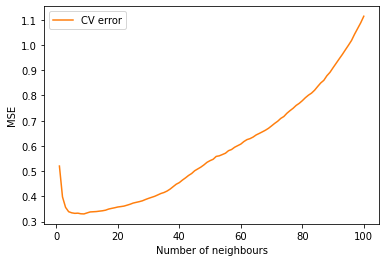

Lowest CV error: K = 9


In [46]:
import matplotlib.pyplot as plt

predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown']

neighbours=np.arange(1, 101)
cv_mse = []

for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': train[predictors].cov()}) 
    scores = cross_val_score(knn, train[predictors], train['Withdraw'], cv=10, scoring = 'neg_mean_squared_error')
    mse = -1*np.mean(scores) # taking the average MSE across folds, then taking the square root
    cv_mse.append(mse)
    knn.fit(train[predictors], train['Withdraw'])

fig, ax= plt.subplots()
ax.plot(neighbours, cv_mse, color='#FF7F0E', label='CV error')
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('MSE')
plt.legend()
plt.show()
  
print('Lowest CV error: K = {}'.format(1 + np.argmin(cv_mse)))

Recall earlier where the predictors 'Shops' and 'Downtown' had a correlation of 0.999131 so we will try to drop it here because of the high correlation.

In [47]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 4
Test MSE : 0.3946
Cross validation MSE : 0.3996


We see that this did not decrease our Test MSE nor our CV MSE so we will add the predictor 'Downtown' back into our model, adding all predictors: <br> Withdraw ~ Shops + Weekday + Center + High + ATMs + Downtown has the lowest CV RMSE currently.

From the interaction terms created earlier, we had predictors: <br> <br>
Shops_SQ = Shops * Shops <br>
ATM_SQ = ATMs * ATMs <br> <br>
Shops_ATM = Shops * ATMs <br>
Shops_Down = Shops * Downtown <br>
Down_ATM = Downtown * ATMs <br>

For now, we will add onto our current model the squared predictors e.g. 'Shops_SQ', 'ATM_SQ'.

In [48]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 8
Test MSE : 0.3298
Cross validation MSE : 0.347


In [49]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'ATM_SQ']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 6
Test MSE : 0.3263
Cross validation MSE : 0.3401


We will keep the model with predictors 'Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ' which gave us a Test MSE = 0.3254

Continue to test interaction terms of the product interaction terms e.g. 'Shops_ATM', 'Shops_Down', 'Down_ATM'.

In [50]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ', 'Shops_ATM']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 8
Test MSE : 0.3223
Cross validation MSE : 0.3379


In [51]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ', 'Shops_Down']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 6
Test MSE : 0.3992
Cross validation MSE : 0.4592


In [52]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ', 'Down_ATM']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 8
Test MSE : 0.3234
Cross validation MSE : 0.336


In [53]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_ATM']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 8
Test MSE : 0.3196
Cross validation MSE : 0.3318


In [54]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_Down']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 6
Test MSE : 0.328
Cross validation MSE : 0.3431


In [55]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Down_ATM']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

Chosen K: 9
Test MSE : 0.3162
Cross validation MSE : 0.3288


In [1]:
response='Withdraw'
predictors=['Shops', 'Weekday', 'Center', 'High', 'ATMs', 'Downtown', 'Shops_SQ', 'ATM_SQ', 'Shops_Down', 'Shops_ATM', 'Down_ATM']
test_mse, cv_mse  =  knn_test(predictors, response) 
print('Test MSE : {}'.format(test_mse.round(4)))
print('Cross validation MSE : {}'.format(cv_mse.round(4)))

NameError: name 'knn_test' is not defined

In [10]:
data

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
0,10.18,10,1,0,0,0,72.750556
1,9.74,10,1,1,0,0,66.720482
2,0.96,2,0,0,0,1,19.189516
3,9.58,9,1,1,0,1,67.388669
4,1.03,4,0,1,0,1,15.813127
...,...,...,...,...,...,...,...
21995,10.15,12,1,0,0,0,71.384290
21996,1.01,2,0,1,0,0,16.031066
21997,0.96,3,0,1,0,0,14.968847
21998,9.91,6,1,0,0,0,73.705665


## Added part

In [26]:
testset = pd.read_csv("ATM_test.csv")
y_true = testset['Withdraw']
testset = testset.drop(['Withdraw'], axis = 1)
formula = "Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High"
model_formula = smf.ols(formula = formula, data = data)
results_formula = model_formula.fit()
y_predict = results_formula.predict(testset)
mse = mean_squared_error(y_true, y_predict)
print(mse)

2.6901677946649256
